# Random Phase Gadgets

Code for producing the family of circuits seen in **Figure 4** from [_A quantum-classical cloud platform optimized for variational hybrid algorithms_](https://arxiv.org/abs/2001.04449).

In [1]:
import random
from typing import Optional

from pyquil import Program, get_qc
from pyquil.gates import CNOT, H, MEASURE, RZ
from pyquil.latex import display
from pyquil.quilbase import Gate

In [2]:
def random_phase_gadget(qubits: int, depth: int, seed: Optional[int] = None) -> Program:
    if seed:
        random.seed(seed)

    pairs = qubits // 2
    alphas =  pairs * depth
    permutation = list(range(qubits))
    random.shuffle(permutation)
    
    i = 0
    p = Program()
    alpha = p.declare("alpha", "REAL", alphas)
    for layer in range(depth):
        for pair in range(pairs):
            control = permutation[2 * pair]
            target = permutation[2 * pair + 1]
            p += H(control)
            p += H(target)
            p += CNOT(control, target)
            p += RZ(alpha[i], target)
            p += CNOT(control, target)
            i += 1
        random.shuffle(permutation)
    
    for qubit in permutation:
        p += H(qubit)

    ro = p.declare("ro", "BIT", qubits)
    for idx, qubit in enumerate(permutation):
        p += MEASURE(qubit, ro[idx])

    return p

In [3]:
m = d = 2
rpg = random_phase_gadget(m, d)
print(rpg)

DECLARE alpha REAL[2]
H 1
H 0
CNOT 1 0
RZ(alpha[0]) 0
CNOT 1 0
H 0
H 1
CNOT 0 1
RZ(alpha[1]) 1
CNOT 0 1
H 0
H 1
DECLARE ro BIT[2]
MEASURE 0 ro[0]
MEASURE 1 ro[1]



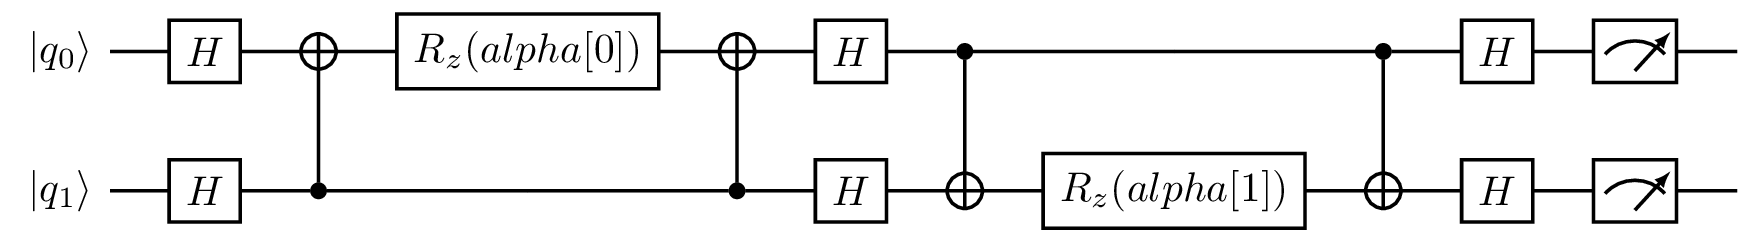

In [4]:
display(rpg)

In [5]:
qvm = get_qc("3q-qvm")

In [6]:
compiled_rpg = Program(qvm.compile(rpg).program)

In [7]:
nCZ = nRX = 0

for gate in compiled_rpg:
    if isinstance(gate, Gate) and gate.name == "CZ":
        nCZ += 1
    if isinstance(gate, Gate) and gate.name == "RX":
        nRX += 1

print(f"Number of CZ gates: {nCZ}")
print(f"Number of RX gates: {nRX}")

Number of CZ gates: 4
Number of RX gates: 16
